In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

0

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [6]:
# http://vis-www.cs.umass.edu/lfw/

In [7]:
# !tar -xf lfw.tgz

In [8]:
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [9]:
# import uuid

In [10]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened(): 
#     ret, frame = cap.read()
   
#     frame = frame[120:120+250,200:200+250, :]
    
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)
    
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)
    
#     cv2.imshow('Image Collection', frame)
    
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
        
# cap.release()
# cv2.destroyAllWindows()

In [11]:
# def data_aug(img):
#     data = []
#     for i in range(9):
#         img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
#         img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
#         # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
#         img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
#         img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
#         img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
#         data.append(img)
    
#     return data

In [12]:
# for file_name in os.listdir(os.path.join(ANC_PATH)):
#     img_path = os.path.join(ANC_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [13]:
# for file_name in os.listdir(os.path.join(POS_PATH)):
#     img_path = os.path.join(POS_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [15]:
dir_test = anchor.as_numpy_iterator()

In [16]:
print(dir_test.next())

b'data\\anchor\\bc807876-62dd-11ee-b5ea-f4463796d376.jpg'


In [17]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

In [33]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [34]:
samples = data.as_numpy_iterator()

In [35]:
example = samples.next()

In [36]:
example

(b'data\\anchor\\b776319c-62dd-11ee-acdc-f4463796d376.jpg',
 b'data\\positive\\c493cad3-62dd-11ee-abd9-f4463796d376.jpg',
 1.0)

In [37]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [38]:
res = preprocess_twin(*example)

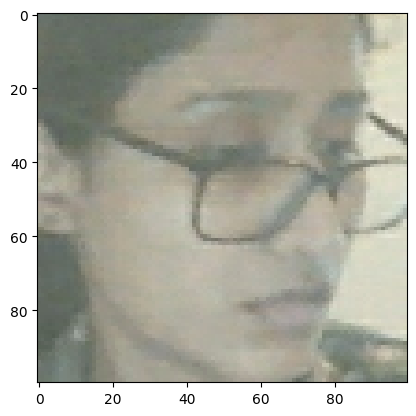

In [39]:
plt.imshow(res[1])

In [16]:
res[2]

1.0

In [17]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [18]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [19]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [20]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [21]:
embedding = make_embedding()

In [22]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [23]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
def make_siamese_model(): 
    
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [25]:
siamese_model = make_siamese_model()

In [26]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [27]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [28]:
opt = tf.keras.optimizers.Adam(1e-4)

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [30]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:   
        
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)

    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [31]:
# from tensorflow.keras.metrics import Precision, Recall

In [32]:
def train(data, EPOCHS):
    
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
         
#         r = Recall()
#         p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
#             yhat = siamese_model.predict(batch[:2])
#             r.update_state(batch[2], yhat)
#             p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
#         print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [33]:
EPOCHS = 12

In [34]:
train(train_data, EPOCHS)


 Epoch 1/12
27/27 [==============================] - 27s 973ms/step

 Epoch 2/12
27/27 [==============================] - 29s 1s/step

 Epoch 3/12
27/27 [==============================] - 29s 1s/step

 Epoch 4/12
27/27 [==============================] - 29s 1s/step

 Epoch 5/12
27/27 [==============================] - 30s 1s/step

 Epoch 6/12
27/27 [==============================] - 28s 1s/step

 Epoch 7/12
27/27 [==============================] - 30s 1s/step

 Epoch 8/12
27/27 [==============================] - 29s 1s/step

 Epoch 9/12
27/27 [==============================] - 27s 996ms/step

 Epoch 10/12
27/27 [==============================] - 26s 958ms/step

 Epoch 11/12
27/27 [==============================] - 26s 946ms/step

 Epoch 12/12
27/27 [==============================] - 26s 946ms/step


In [35]:
from tensorflow.keras.metrics import Precision, Recall

In [36]:
y_true = []
y_hat = []

for each in test_data:
    
    y_true.extend(each[2])
    y_hat.extend(siamese_model.predict(each[:2]))
                 
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 [==============================] - 0s 59ms/step


1.0 1.0


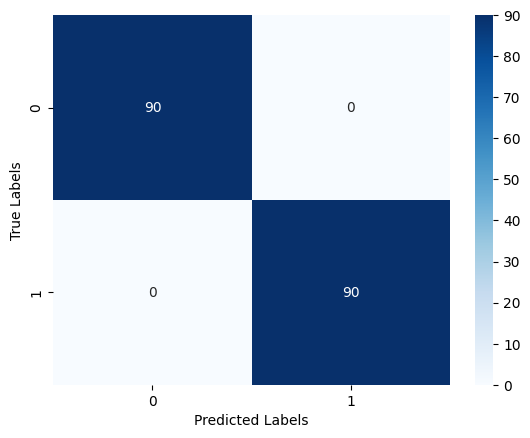

In [37]:
r = Recall()
p = Precision()

r.update_state(y_true, y_hat)
p.update_state(y_true, y_hat)

confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

print(r.result().numpy(), p.result().numpy())

sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [38]:
siamese_model.save('siamesemodel.h5')

C:\Users\Sreeja Gaddamidi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist})

In [40]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [41]:
def verify(model, detection_threshold, verification_threshold):
    
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [45]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
    
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 34ms/step
True


In [17]:
np.sum(np.squeeze(results) > 0.9)

36

In [18]:
results

[array([[0.9944859]], dtype=float32),
 array([[0.9999912]], dtype=float32),
 array([[0.9999943]], dtype=float32),
 array([[0.9999951]], dtype=float32),
 array([[0.99993753]], dtype=float32),
 array([[0.9082498]], dtype=float32),
 array([[0.9999846]], dtype=float32),
 array([[0.9834683]], dtype=float32),
 array([[0.87159216]], dtype=float32),
 array([[0.7328309]], dtype=float32),
 array([[0.74533516]], dtype=float32),
 array([[0.949607]], dtype=float32),
 array([[0.7501703]], dtype=float32),
 array([[0.60669833]], dtype=float32),
 array([[0.93921214]], dtype=float32),
 array([[0.9813106]], dtype=float32),
 array([[0.9848625]], dtype=float32),
 array([[0.89696234]], dtype=float32),
 array([[0.98896575]], dtype=float32),
 array([[0.99082947]], dtype=float32),
 array([[0.7747197]], dtype=float32),
 array([[0.99999297]], dtype=float32),
 array([[0.99986887]], dtype=float32),
 array([[0.9999764]], dtype=float32),
 array([[0.90808266]], dtype=float32),
 array([[0.8795649]], dtype=float32),
 a